In [384]:
from webscraper.scrap_modules import my_NLP as myNLP 
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test Code - NLP

load cleaned dataframe

In [385]:
with open("webscraper/cleaned_data/cleaned_dataframe.pkl", "rb") as file:
    df = pickle.load(file)
    

In [386]:
df.head(2)

,id,title,company,city,posting_date,job_description,seniority_level,employment_type,job_function,industries,scraping_date,url,keyword
0,3685669741,Software Engineer Fullstack (m/w/d),Atruvia AG,"Aschheim, Bavaria, Germany",1 day ago,VollzeitWir sind der Digitalisierungspartner d...,Entry level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,Data Scientist
1,3719620327,Data Analyst - Business Intelligence,Almedia,"Berlin, Berlin, Germany",5 days ago,Almedia helps companies grow by promoting thei...,Mid-Senior level,Full-time,Analyst,"Technology, Information and Internet",2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,Data Analyst


#### Language detection

In [389]:
dataframe['language'].value_counts()

language
de    12434
en     8495
fr        7
nl        2
pl        1
it        1
ko        1
Name: count, dtype: int64

#### Keyword Extraction 
https://www.analyticsvidhya.com/blog/2022/03/keyword-extraction-methods-from-documents-in-nlp/#:~:text=Textrank%20is%20a%20Python%20tool,compatible%20with%20the%20Spacy%20pipeline

In [390]:
import spacy 
import pytextrank 
import pandas as pd
import re

# !spacy download en_core_web_sm
# !spacy download de_core_news_sm

remove gender designations

In [391]:
nlp_df = pd.DataFrame(df)

In [392]:
# first regex manipulation 
# removing gender and symbols
nlp_df['cp1_title'] = nlp_df["title"].progress_apply(myNLP.clean_up)

Processing:   0%|          | 1/20941 [00:00<?, ?it/s]


error: nothing to repeat at position 0

In [ ]:
nlp_df['cp1_title']


0                              software engineer fullstack
1                      data analyst  business intelligence
2                                   (junior) data engineer
3                                   financial data analyst
4                            business intelligence analyst
                               ...                        
20936    softwareentwickler:in frontend ()  100% home o...
20937        dr. rer. nat. physik  simulation  experimente
20938    (senior) manager process automation   ai  data...
20939                                   software-architect
20940                      php developer   remote possible
Name: cp1_title, Length: 20941, dtype: object

remove text in parentheses

In [ ]:
pattern_to_extract = r'\((.*?)\)'

# Extract text within parentheses and put it in a new column
nlp_df['text_in_parentheses'] = nlp_df['cp1_title'].progress_apply(lambda x: re.findall(pattern_to_extract, x))

# Convert lists with only one element to that element, and keep lists for multiple elements
nlp_df['text_in_parentheses'] = nlp_df['text_in_parentheses'].progress_apply(lambda x: x[0] if len(x) == 1 else x)

# Remove the text within parentheses 
nlp_df['cp1_title'] = nlp_df['cp1_title'].progress_apply(lambda x: re.sub(pattern_to_extract, '', x).strip())


Processing: 100%|██████████| 20941/20941 [00:00<00:00, 625880.36it/s]


clean dataframe based on several rounds of inspecting word clouds 

In [ ]:
words_to_find = ['medizin','solution architect', 'devops', 'software', 'student', 'werkstudent', 'consultant', 'studium', 'senior', 'manager', 'wissenschaftlich']


nlp_df['exclude'] = nlp_df['cp1_title'].apply(lambda x: 'True' if any(word.lower() in x.lower() for word in words_to_find) else 'False')


In [ ]:
print(nlp_df.shape)
nlp_df = nlp_df[nlp_df['exclude']=="False"]

print(nlp_df.shape)

all_text = nlp_df['cp1_title']

total_text = " ".join(all_text) # combining all job title 

(20941, 16)
(10333, 16)


### Tokenize, lemmatize, remove stopwords

In [ ]:
nlp_df['cp2_title'] = nlp_df['cp1_title'].progress_apply(myNLP.tokenize)
nlp_df['cp2_title'] = nlp_df['cp2_title'].progress_apply(myNLP.stem_and_lemmatize)
nlp_df['cp2_title'] = nlp_df['cp2_title'].progress_apply(myNLP.remove_stopwords)
nlp_df['cp2_title'] = nlp_df['cp2_title'].progress_apply(myNLP.re_blob) 



Processing: 100%|██████████| 10333/10333 [00:00<00:00, 784770.64it/s]


In [ ]:
title_list = nlp_df['cp2_title'].tolist()
title_list

['data analyst business intelligence',
 'data engineer',
 'financial data analyst',
 'business intelligence analyst',
 'data analyst',
 'data analyst',
 'bi analyst',
 'data analyst',
 'product data analyst',
 'data analyst',
 'data analyst customer data',
 'data analyst',
 'young professional client data analyst ←',
 'data analyst',
 'business process data analyst',
 'data analyst system developer',
 'data analyst vie',
 'data analyst engineer',
 'data analyst klimadaten',
 'business intelligence analyst germany remote',
 'data analyst marketing-bereich',
 'analytics engineer',
 'data extraction and analysis engineer',
 'data scientist data analyst',
 'data engineer',
 'data engineer',
 'data analyst controller business intelligence',
 'business analyst data analyst logistik strategische beratung bahnwirtschaft',
 'data engineer',
 'esg-data impact reporting analyst',
 'cloud data analyst',
 'young professional client data analyst ←',
 'data engineer',
 'data engineer specialist',
 'd

In [ ]:
bag = []
bag = " ".join(title_list)
bag

"data analyst business intelligence data engineer financial data analyst business intelligence analyst data analyst data analyst bi analyst data analyst product data analyst data analyst data analyst customer data data analyst young professional client data analyst ← data analyst business process data analyst data analyst system developer data analyst vie data analyst engineer data analyst klimadaten business intelligence analyst germany remote data analyst marketing-bereich analytics engineer data extraction and analysis engineer data scientist data analyst data engineer data engineer data analyst controller business intelligence business analyst data analyst logistik strategische beratung bahnwirtschaft data engineer esg-data impact reporting analyst cloud data analyst young professional client data analyst ← data engineer data engineer specialist data center engineer l2 analyst associate berlin business analyst credit business analyst financial instrument and risk data scientist bus

#### word cloud 

In [ ]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS

In [ ]:
def word_cloud(text):   
    stopwords = STOPWORDS
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(text)
    rcParams['figure.figsize'] = 10, 20
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    filtered_words = [word for word in text.split() if word not in stopwords]
    counted_words = collections.Counter(filtered_words)
    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)
    colors = cm.rainbow(np.linspace(0, 1, 10))
    rcParams['figure.figsize'] = 20, 10
    plt.title('Top words in the headlines vs their count')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)
    plt.show()

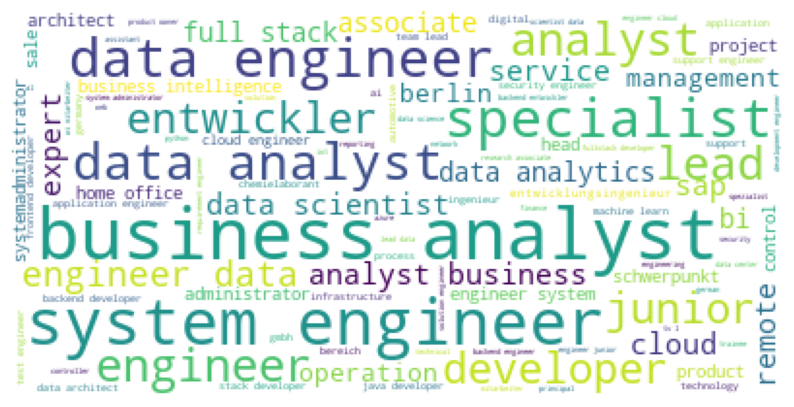

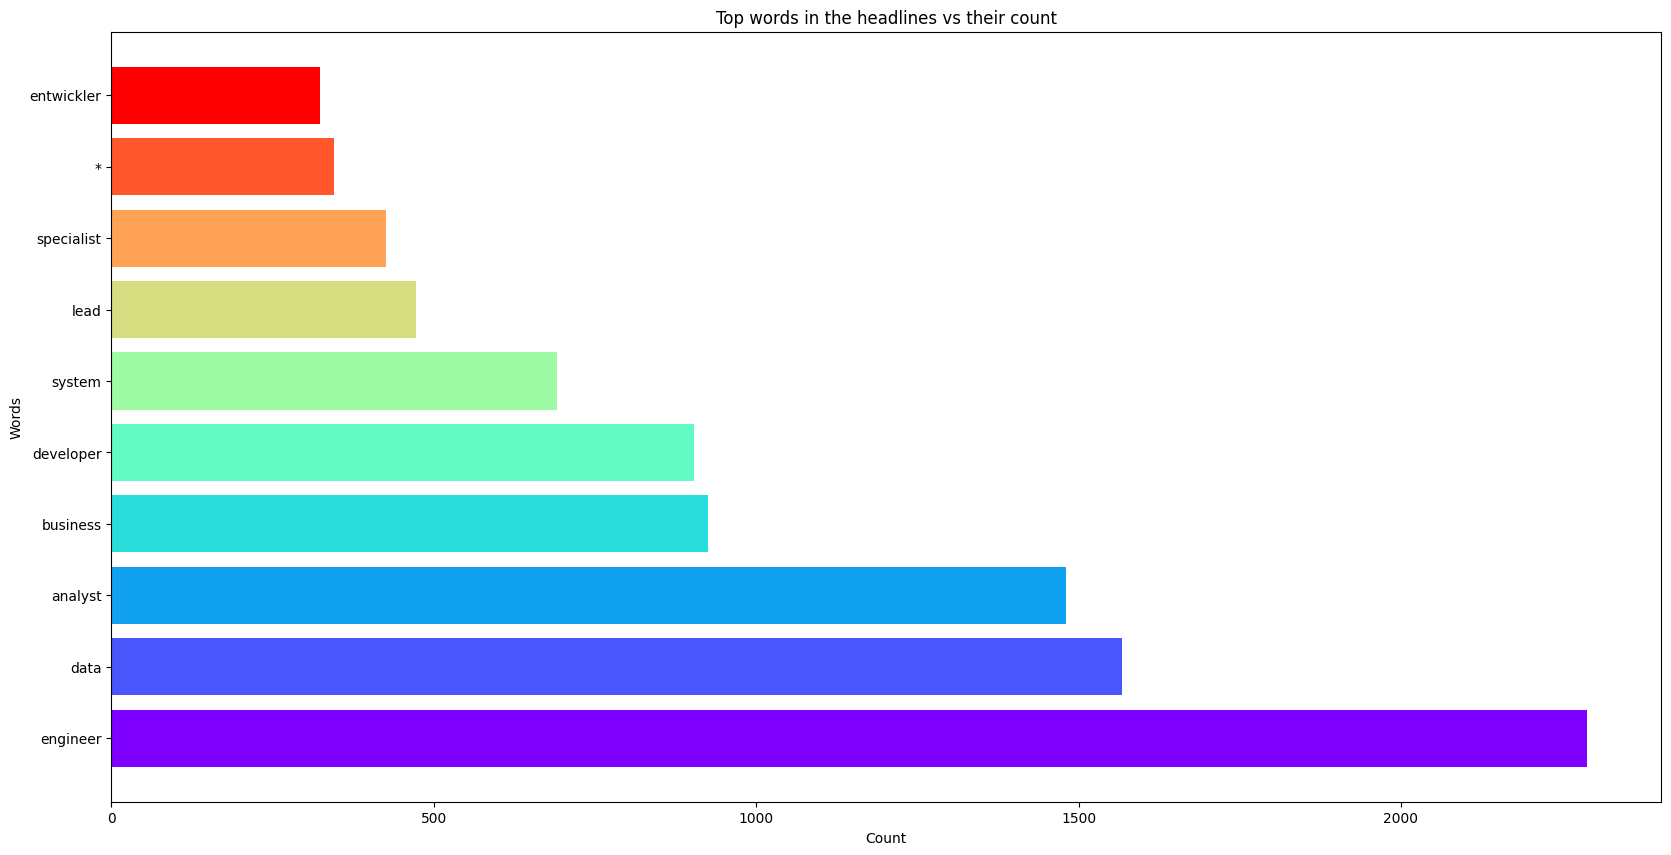

In [ ]:
word_cloud(bag)

Yake keyword extractor

In [ ]:
import yake

kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(bag)

In [ ]:
for kw in keywords:
    print(kw)

('data engineer data', 1.068721621145104e-06)
('engineer data engineer', 1.205575279180061e-06)
('engineer system engineer', 2.1958149441020613e-06)
('analyst business analyst', 2.2510592678934974e-06)
('data analyst data', 3.1427747985703383e-06)
('business analyst business', 3.557277996611398e-06)
('engineer data analyst', 5.194348204214538e-06)
('analyst data analyst', 5.482375676320627e-06)
('data engineer', 5.989150970516187e-06)
('analyst data engineer', 7.027647570407905e-06)
('business analyst', 7.4729792958894e-06)
('system engineer', 8.038637858960961e-06)
('engineer business analyst', 9.721140019582984e-06)
('data analyst', 1.0201135362013598e-05)
('data scientist data', 1.0814301495359677e-05)
('engineer data', 1.1943481295854956e-05)
('system engineer system', 1.751370306232793e-05)
('engineer', 1.816980026349377e-05)
('scientist data analyst', 1.832105035807657e-05)
('cloud data engineer', 1.8411370829358564e-05)


In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Data Preprocessing
## Lowercasing

## Tokenization and Removing Stop Words
stop_words = set(stopwords.words('english'))
nlp_df['cp1_title'] = nlp_df['cp1_title'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

## Stemming
stemmer = PorterStemmer()
nlp_df['cp1_title'] = nlp_df['cp1_title'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

# Step 2: Text Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(nlp_df['cp1_title'])

# # Step 3: Clustering
# kmeans = KMeans(n_clusters=5)  # Assuming 5 clusters
# kmeans.fit(X)
# nlp_df['cluster_kmeans'] = kmeans.labels_



# Step 4: Evaluation
# Manually evaluate the clusters or use metrics

# Step 5: Visualization (Optional)
# Use Matplotlib or Seaborn to visualize clusters

c:\Users\Domen\IronHack\01_projects\IH_final_project_data-jobs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: x and y must have same first dimension, but have shapes (10,) and (29,)

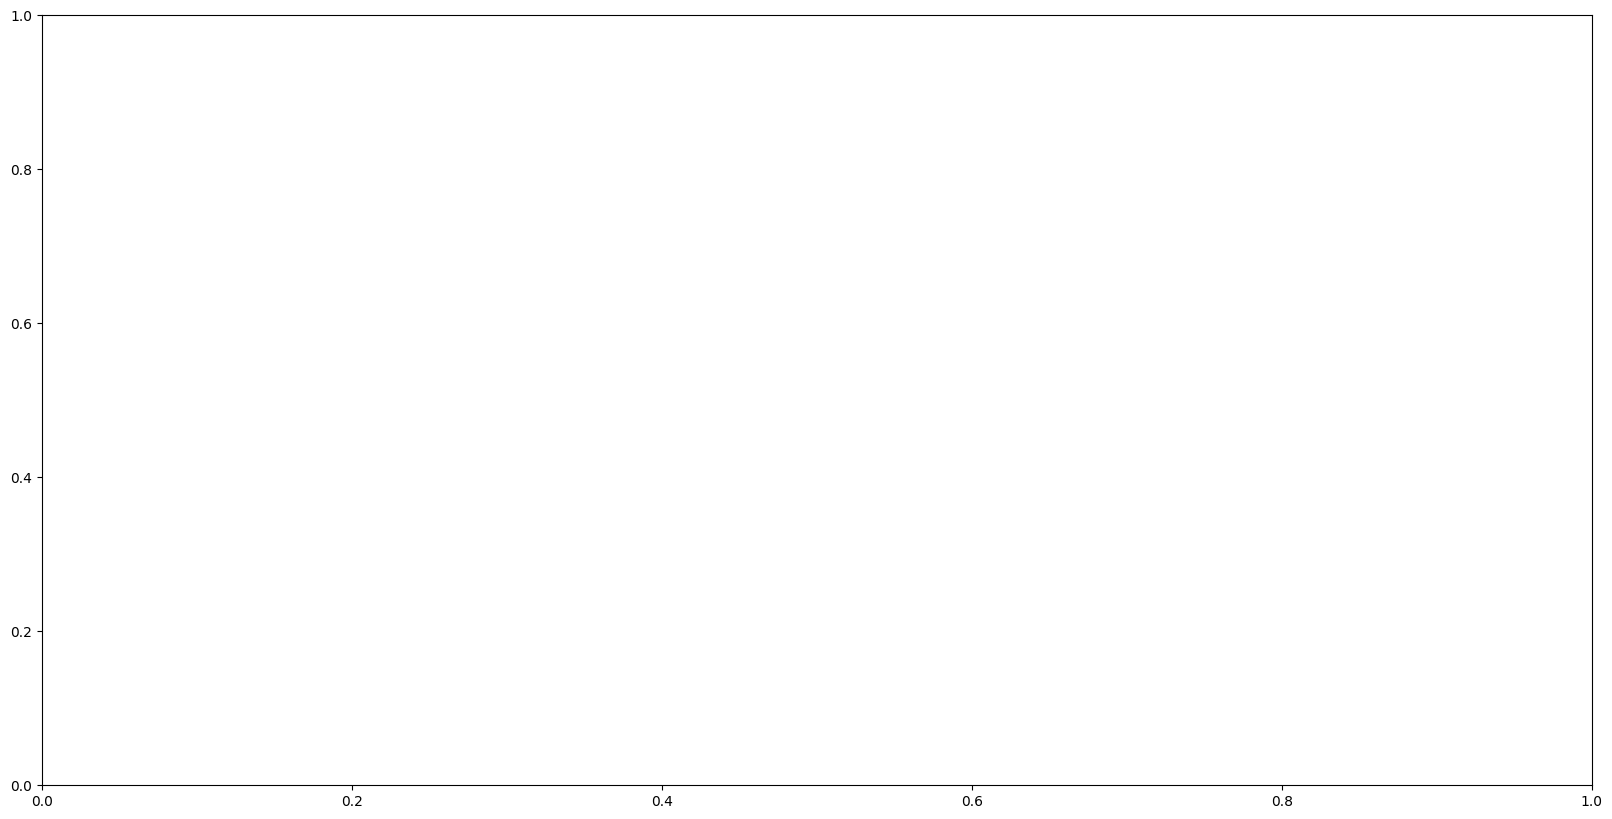

In [ ]:
# Elbow Method to find optimal K
inertia = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Initialize variables
silhouette_scores = []
inertia = []
# Loop through different numbers of clusters
for i in range(2, 30):  # Start from 2 as silhouette_score needs at least 2 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    
    inertia.append(kmeans.inertia_)
    
    # Calculate the silhouette score and append to the list
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {i}, the silhouette score is {silhouette_avg}")

# Plotting the silhouette scores
plt.plot(range(2, 30), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()



plt.plot(range(2, 30), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
filtered_df = nlp_df[nlp_df['cp2_title'].str.contains("medizin", case=False)]
filtered_df


,id,title,company,city,posting_date,job_description,seniority_level,employment_type,job_function,industries,scraping_date,url,keyword,cp1_title,text_in_parentheses,exclude,cp2_title
844,3723230363,"PostDoc Biology - Oncology Research, Immunolog...",Charité - Universitätsmedizin Berlin,"Berlin, Berlin, Germany",3 days ago,THE CHARITÉ - UNIVERSITÄTSMEDIZIN BERLINThe Ch...,Mid-Senior level,Full-time,Science,Biotechnology Research,2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,Data,postdoc biolog oncolog research immunolog char...,[],False,postdoc biology oncology research immunology c...
1722,3689374446,Fullstack-Entwickler*in Digitale Medizin - Berlin,Fraunhofer Karriere,"Berlin, Berlin, Germany",2 weeks ago,Fraunhofer MEVIS ist ein weltweit führendes un...,Entry level,Full-time,Engineering and Information Technology,Research Services,2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,Data Scientist,fullstack entwickl * digital medizin berlin,[],False,fullstack entwickler * digitale medizin berlin
4053,3702458592,Systems Engineer - Medizintechnik (w/m/d),Capgemini Engineering,"Berlin, Berlin, Germany",1 week ago,Herzlich Willkommen im Bereich Life Sciences. ...,Associate,Full-time,Information Technology,IT Services and IT Consulting,2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,Data Analyst,system engin medizintechnik,[],False,system engineer medizintechnik
8887,3706531672,Data Analyst (m/w/d) Business Management Mediz...,Dräger,"Lübeck, Schleswig-Holstein, Germany",2 weeks ago,Dafür suchen wir DichIn unserer Business Unit ...,Entry level,Full-time,Information Technology,Manufacturing,2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,data,data analyst busi manag medizintechnik,[],False,data analyst business management medizintechnik
9025,3724873320,Medizincontrollerin / Medizincontroller,Universitätsklinikum Frankfurt am Main,"Frankfurt, Hesse, Germany",2 days ago,(wir richten uns mit dieser Ausschreibung an B...,Mid-Senior level,Full-time,Health Care Provider,Hospitals and Health Care,2023-09-24,https://www.linkedin.com/jobs/search?keywords=...,data,medizincontrollerin medizincontrol,[],False,medizincontrollerin medizincontroller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19308,3701557141,Pflegepädagoge/Medizinpädagoge (B.A./M.A./Dipl...,join.com,"Flensburg, Schleswig-Holstein, Germany",4 weeks ago,Das Ökumenische Bildungszentrum für Berufe im ...,Mid-Senior level,Full-time,Health Care Provider,Primary and Secondary Education,2023-09-25,https://www.linkedin.com/jobs/search?keywords=...,Data Operations Analyst,pflegepädagog medizinpädagog ökumenisch bildun...,b.a. m.a. diplom m w d,False,pflegepädagoge medizinpädagoge at ökumenisches...
19688,3709916971,Analyst für das Beschwerdemanagement Pharma / ...,HOX Life Science GmbH,"Frankfurt, Hesse, Germany",2 weeks ago,Gerade in der Pharma- und Medizinprodukteindus...,Entry level,Full-time,Other,Pharmaceutical Manufacturing,2023-09-25,https://www.linkedin.com/jobs/search?keywords=...,Predictive Analyst,analyst für da beschwerdemanag pharma medizinp...,[],False,analyst beschwerdemanagement pharma medizinpro...
20333,3723243402,Wiss. Mitarbeiter*in für den Bereich Veterinär...,Freie Universität Berlin,"Berlin, Berlin, Germany",6 days ago,Fachbereich Veterinärmedizin – Institut für Vi...,Entry level,Full-time,"Research, Analyst, and Information Technology",Research Services,2023-09-25,https://www.linkedin.com/jobs/search?keywords=...,Statistics,wiss . mitarbeit * für den bereich veterinärme...,[],False,wi . mitarbeiter * bereich veterinärmedizin be...
20442,3717790813,Bioinformatiker*in im Omics-Bereich der Medizi...,Ruhr University Bochum,"Bochum, North Rhine-Westphalia, Germany",1 week ago,Wiss. Mitarbeiter*in als Bioinformatiker*in im...,None,None,None,None,2023-09-25,https://www.linkedin.com/jobs/search?keywords=...,Algorithms,bioinformatik * im omic bereich der medizinisc...,[],False,bioinformatiker * omi